In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import Imputer, LabelEncoder, StandardScaler, scale
from sklearn.decomposition import PCA


In [0]:
df = pd.read_csv('./baseline_data.csv',header=0,low_memory=False)

In [0]:
Catdata = df.loc[0:,'PTETHCAT':'APOE4'].join(df['PTGENDER']).join(df['imputed_genotype'])
for i in Catdata.columns:
    the_value = str(Catdata[i].mode().values[0]) # find the most common value in the column
    Catdata[i].replace('NaN',the_value,inplace = True)
    dummy_data = pd.get_dummies(Catdata[i], prefix=i+"_", drop_first=True) # https://www.jianshu.com/p/c324f4101785
    Catdata = pd.concat([Catdata, dummy_data], axis=1)
    Catdata.drop(i, axis=1, inplace=True)

Numdata = df.iloc[:,0:2150].join(df['AGE']).join(df['PTEDUCAT']).join(df['MMSE'])

scaler = StandardScaler()
data = Numdata.join(Catdata)
scaler.fit(data)
data = pd.DataFrame(scaler.transform(data))

labels = df['DX.bl']
le = LabelEncoder()
le.fit(labels) # http://sofasofa.io/forum_main_post.php?postid=1001659
labels = le.transform(labels)
labels = labels.astype('float') # 1 CN, 0 AD, 2 LMCI

print((data.shape))

(628, 2161)


In [0]:
# find the best number of features using PCA
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

kfold = model_selection.KFold(n_splits=10, random_state=7)
num_trees = 10
logisticRegr=[]
train_acr=[]
test_acr=[]
for npca in range(1,50):
    #print(npca*10)
    pca = PCA(n_components = npca*10)
    data_reduced=pca.fit_transform(data)
    X_train, X_test, y_train, y_test = train_test_split(data_reduced, labels, test_size = 0.2, random_state = 2)
    logisticRegr.append(LogisticRegression())
    logisticRegr[npca-1].fit(X_train,y_train)
    # accuracy on train and test model
    #print(logisticRegr[npca-1].score(X_train,y_train),logisticRegr[npca-1].score(X_test,y_test))
    train_acr.append(logisticRegr[npca-1].score(X_train,y_train))
    test_acr.append(logisticRegr[npca-1].score(X_test,y_test))

D:\Programs\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


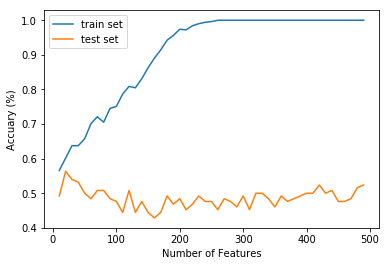

In [0]:
import matplotlib.pyplot as plt  
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(list(range(10,500,10)),train_acr,label='train set')
plt.plot(list(range(10,500,10)),test_acr,label='test set')
plt.xlabel('Number of Features')
plt.ylabel('Accuary (%)') #for each component
plt.legend()
#plt.title('Diabetes Dataset Explained Variance')
plt.show()

# PCA can not help OVERFITTING

In [0]:
# find the best regularization parameter using CV
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression

kfold = model_selection.KFold(n_splits=10, random_state=7)
num_trees = 10
pca = PCA(n_components = 300)
data_reduced=pca.fit_transform(data)
for cc in range(11):
    lrf = LogisticRegression(C=0.1+cc*0.1,random_state=7)
    model = BaggingClassifier(base_estimator=lrf, n_estimators=num_trees, random_state=7)
    results = model_selection.cross_val_score(model, data_reduced, labels, cv=kfold)
    print(cc,results.mean())

# Regularization can not help OVERFITTING, either

0 0.5093958013312851
1 0.5093958013312851
2 0.5014336917562723
3 0.4998463901689707
4 0.5046338965693804
5 0.5046082949308756
6 0.5046338965693804
7 0.5014336917562724
8 0.5014336917562724
9 0.5014336917562724
10 0.4998463901689708


In [0]:
# Using bagging with 300 features and C=1 in regularization
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier

gp = GaussianProcessClassifier(optimizer='Welch',multi_class='one_vs_rest',n_restarts_optimizer=5)
kfold = model_selection.KFold(n_splits=10, random_state=7)
#lrf = LogisticRegression()
num_trees = 10
model = BaggingClassifier(base_estimator=lrf, n_estimators=num_trees, random_state=7)
results = model_selection.cross_val_score(model, data_reduced, labels, cv=kfold)
print(results.mean())

0.5014336917562724


In [0]:
# Manually select different set of features, training different model and voting in the end
Numdata_new = [];
feature_dis = 25
for i in range(feature_dis):
    Numdata_new.append(df.iloc[:,i:2150:feature_dis].join(df['AGE']).join(df['PTEDUCAT']).join(df['MMSE']))

scaler = StandardScaler()
logisticRegr=[]
for i in range(feature_dis):
    data_new = Numdata_new[i].join(Catdata)
    scaler.fit(data_new)
    data_new = pd.DataFrame(scaler.transform(data_new))
    X_train, X_test, y_train, y_test = train_test_split(data_new, labels, test_size = 0.2, random_state = 2)
    logisticRegr.append(LogisticRegression())
    logisticRegr[i].fit(X_train,y_train)
    # accuracy on training and test model
    print(i,logisticRegr[i].score(X_train,y_train),logisticRegr[i].score(X_test,y_test))
    


0 0.8127490039840638 0.6190476190476191
1 0.7928286852589641 0.5873015873015873
2 0.8187250996015937 0.626984126984127
3 0.8346613545816733 0.6904761904761905
4 0.7928286852589641 0.6190476190476191
5 0.8087649402390438 0.6031746031746031
6 0.8167330677290837 0.6031746031746031
7 0.8007968127490039 0.6349206349206349
8 0.8047808764940239 0.6190476190476191
9 0.8227091633466136 0.6587301587301587
10 0.8087649402390438 0.6587301587301587
11 0.8286852589641435 0.5873015873015873
12 0.8326693227091634 0.6587301587301587
13 0.7888446215139442 0.6190476190476191
14 0.7808764940239044 0.6507936507936508
15 0.7888446215139442 0.6190476190476191
16 0.798804780876494 0.6587301587301587
17 0.8027888446215139 0.6111111111111112
18 0.8027888446215139 0.626984126984127
19 0.8067729083665338 0.6111111111111112
20 0.8167330677290837 0.6666666666666666
21 0.8286852589641435 0.6031746031746031
22 0.8247011952191236 0.6666666666666666
23 0.8187250996015937 0.6031746031746031
24 0.796812749003984 0.626984

In [0]:
from sklearn.metrics import f1_score
# voting based on different models and find the accuracy
y_predict=[]
for i in range(feature_dis):
    y_predict.append(logisticRegr[i].predict(X_test))
YY_predict_all=pd.DataFrame(y_predict)
YY_predict=[]
for i in YY_predict_all.columns:
    the_value = YY_predict_all[i].mode().values[0] # find the most common value in the column
    YY_predict.append(the_value)
count=0
for i in range(len(YY_predict)):
    if YY_predict[i]==y_test[i]:
        count+=1
accuarcy = count/len(YY_predict)
print(accuarcy)
print(f1_score(y_test,YY_predict,average='micro'))


0.6904761904761905
0.6904761904761905
